In [1]:
from math import sqrt

import matplotlib.pyplot as plt
import torch
from torchfem import Planar
from torchfem.elements import Quad1
from torchfem.materials import IsotropicPlaneStress

# Set plot to use TeX for rendering equations.
plt.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = 14

torch.set_default_dtype(torch.double)

In [2]:
def get_cantilever(size, Lx, Ly, d=1.0, E=100, nu=0.3, etype=Quad1()):
    # Material
    material = IsotropicPlaneStress(E, nu)

    # Dimensions
    Nx = int(Lx / size)
    Ny = int(Ly / size)

    # Create nodes
    n1 = torch.linspace(0.0, Lx, Nx + 1)
    n2 = torch.linspace(0.0, Ly, Ny + 1)
    n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
    nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

    # Create elements connecting nodes
    elements = []
    for j in range(Ny):
        for i in range(Nx):
            if isinstance(etype, Quad1):
                # Quad elements
                n0 = i + j * (Nx + 1)
                elements.append([n0, n0 + 1, n0 + Nx + 2, n0 + Nx + 1])
            else:
                # Tria elements
                n0 = i + j * (Nx + 1)
                elements.append([n0, n0 + 1, n0 + Nx + 2])
                elements.append([n0 + Nx + 2, n0 + Nx + 1, n0])
    elements = torch.tensor(elements)

    cantilever = Planar(nodes, elements, material)

    # Load at tip
    cantilever.forces[(int((Ny + 1) / 2) + 1) * (Nx + 1) - 1, 1] = -1.0

    # Constrained displacement at left end
    for i in range(Ny + 1):
        cantilever.constraints[i * (Nx + 1), :] = True

    # Default
    cantilever.thickness[:] = d

    return cantilever

## Define the cantilever problem

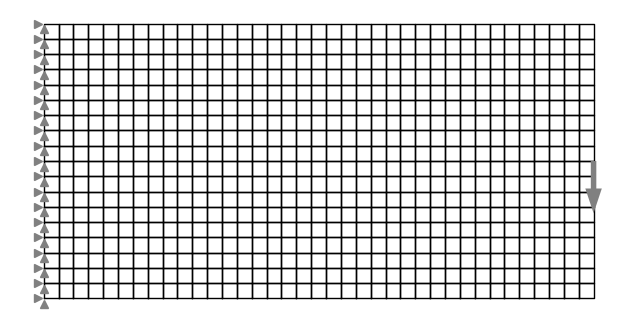

In [3]:
cantilever = get_cantilever(0.75, 28.0, 14.0)
cantilever.plot()

## Optimization with MMA

In [4]:
def bisection(f, a, b, max_iter=50, tol=1e-10):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c


def compute_areas(truss):
    areas = torch.zeros((truss.n_elem))
    nodes = truss.nodes[truss.elements, :]
    for w, q in zip(truss.etype.iweights(), truss.etype.ipoints()):
        J = truss.etype.B(q) @ nodes
        detJ = torch.linalg.det(J)
        areas[:] += w * detJ
    return areas


def optimize_mma(fem, rho_0, rho_min, rho_max, V_0, iter=15, s=0.9, p=1.0, r_sens=0.0):
    k0 = torch.einsum("i,ijk->ijk", 1.0 / fem.thickness, fem.k())
    rho = [rho_0]
    L = []
    areas = compute_areas(fem)

    # Precompute filter weights
    if r_sens > 0.0:
        ecenters = torch.stack([torch.mean(fem.nodes[e], dim=0) for e in fem.elements])
        dist = torch.cdist(ecenters, ecenters)
        H = r_sens - dist
        H[dist > r_sens] = 0.0

    # Check if there is a feasible solution before starting iteration
    if torch.inner(rho_min, areas) > V_0:
        raise Exception("rho_min is not compatible with V_0.")

    # Iterate solutions
    for k in range(iter):
        # Solve the problem at rho_k
        fem.thickness = rho[k] ** p
        u_k, f_k = fem.solve()

        # Compute sensitivity
        disp = u_k[fem.elements, :].reshape(fem.n_elem, -1)
        w_k = 0.5 * torch.einsum("...i,...ij,...j", disp, k0, disp)
        sensitivity = -p * rho[k] ** (p - 1) * 2.0 * w_k

        # Filter sensitivities (if r_sens provided)
        if r_sens > 0.0:
            sensitivity = H @ (rho[k] * sensitivity) / H.sum(dim=0) / rho[k]

        # Compute lower asymptote
        if k <= 1:
            L.append(rho[k] - s * (rho_max - rho_min))
        else:
            L_k = torch.zeros_like(L[k - 1])
            osci = (rho[k] - rho[k - 1]) * (rho[k - 1] - rho[k - 2]) < 0.0
            L_k[osci] = rho[k][osci] - s * (rho[k - 1][osci] - L[k - 1][osci])
            L_k[~osci] = rho[k][~osci] - 1 / sqrt(s) * (
                rho[k - 1][~osci] - L[k - 1][~osci]
            )
            L.append(L_k)

        # Compute lower move limit in this step
        rho_min_k = torch.max(rho_min, 0.9 * L[k] + 0.1 * rho[k])

        # Analytical solution
        def rho_star(mu):
            rho_hat = L[k] + torch.sqrt(
                (-sensitivity * (L[k] - rho[k]) ** 2) / (mu * areas)
            )
            return torch.clamp(rho_hat, rho_min_k, rho_max)

        # Analytical gradient
        def grad(mu):
            return torch.dot(rho_star(mu), areas) - V_0

        # Solve dual problem
        mu_star = bisection(grad, 0.0, 100.0)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k:3d} - Compliance: {compliance:.5f}")

        # Compute current optimal point with dual solution
        rho.append(rho_star(mu_star))

    return rho

## Variable thickness optimization (p=1)

Iteration k=  0 - Compliance: 0.78348
Iteration k=  1 - Compliance: 0.58562
Iteration k=  2 - Compliance: 0.58086
Iteration k=  3 - Compliance: 0.56605
Iteration k=  4 - Compliance: 0.56055
Iteration k=  5 - Compliance: 0.55596
Iteration k=  6 - Compliance: 0.55339
Iteration k=  7 - Compliance: 0.55251
Iteration k=  8 - Compliance: 0.55184
Iteration k=  9 - Compliance: 0.55158
Iteration k= 10 - Compliance: 0.55134
Iteration k= 11 - Compliance: 0.55126
Iteration k= 12 - Compliance: 0.55118
Iteration k= 13 - Compliance: 0.55113
Iteration k= 14 - Compliance: 0.55110
Iteration k= 15 - Compliance: 0.55107
Iteration k= 16 - Compliance: 0.55105
Iteration k= 17 - Compliance: 0.55104
Iteration k= 18 - Compliance: 0.55103
Iteration k= 19 - Compliance: 0.55102
Iteration k= 20 - Compliance: 0.55102
Iteration k= 21 - Compliance: 0.55102
Iteration k= 22 - Compliance: 0.55101
Iteration k= 23 - Compliance: 0.55101
Iteration k= 24 - Compliance: 0.55101


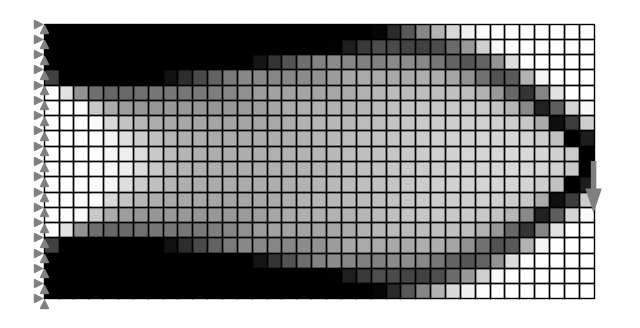

In [5]:
rho_0 = 0.5 * torch.ones(len(cantilever.elements))
rho_min = 0.1 * torch.ones_like(rho_0)
rho_max = 1.0 * torch.ones_like(rho_0)
areas = compute_areas(cantilever)
V0 = 0.5 * torch.inner(rho_max, areas)

rho_opt = optimize_mma(cantilever, rho_0, rho_min, rho_max, V0, iter=25)
cantilever.plot(element_property=rho_opt[-1], cmap="gray_r")
plt.savefig(
    "../figures/cantilever_fem_optimized.svg", transparent=True, bbox_inches="tight"
)

## SIMP approach for binarization

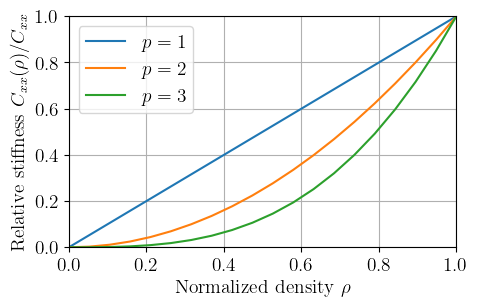

In [6]:
p = 3
Cxx = 1.0

# Plot the SIMP relation
rho = torch.linspace(0, 1, 20)
plt.figure(figsize=(5, 3))
plt.plot(rho, Cxx * rho**1.0, label="$p=1$")
plt.plot(rho, Cxx * rho**2.0, label="$p=2$")
plt.plot(rho, Cxx * rho**3.0, label="$p=3$")
plt.xlabel(r"$\textrm{Normalized density } \rho$")
plt.ylabel(r"$\textrm{Relative stiffness } C_{xx}(\rho)/C_{xx}$")
plt.xlim([0, 1])
plt.ylim([0, Cxx])
plt.legend()
plt.grid()
plt.savefig("../figures/simp.svg", transparent=True, bbox_inches="tight")

Iteration k=  0 - Compliance: 3.13393
Iteration k=  1 - Compliance: 3.51266
Iteration k=  2 - Compliance: 5.28577
Iteration k=  3 - Compliance: 2.73529
Iteration k=  4 - Compliance: 1.46228
Iteration k=  5 - Compliance: 1.06049
Iteration k=  6 - Compliance: 0.88839
Iteration k=  7 - Compliance: 0.83167
Iteration k=  8 - Compliance: 0.81168
Iteration k=  9 - Compliance: 0.80092
Iteration k= 10 - Compliance: 0.79512
Iteration k= 11 - Compliance: 0.79241
Iteration k= 12 - Compliance: 0.79032
Iteration k= 13 - Compliance: 0.78968
Iteration k= 14 - Compliance: 0.78866
Iteration k= 15 - Compliance: 0.78766
Iteration k= 16 - Compliance: 0.78605
Iteration k= 17 - Compliance: 0.78527
Iteration k= 18 - Compliance: 0.78517
Iteration k= 19 - Compliance: 0.78512
Iteration k= 20 - Compliance: 0.78508
Iteration k= 21 - Compliance: 0.78499
Iteration k= 22 - Compliance: 0.78473
Iteration k= 23 - Compliance: 0.78424
Iteration k= 24 - Compliance: 0.78423
Iteration k= 25 - Compliance: 0.78422
Iteration k=

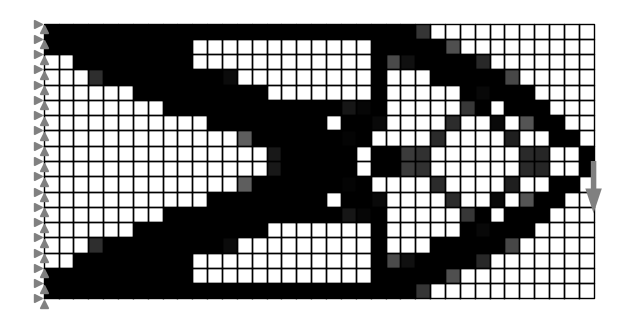

In [7]:
rho_opt = optimize_mma(cantilever, rho_0, rho_min, rho_max, V0, p=3, iter=50)
cantilever.plot(element_property=rho_opt[-1], cmap="gray_r")
plt.savefig(
    "../figures/cantilever_fem_optimized_binary.svg",
    transparent=True,
    bbox_inches="tight",
)

Iteration k=  0 - Compliance: 3.13393
Iteration k=  1 - Compliance: 3.63990
Iteration k=  2 - Compliance: 5.51123
Iteration k=  3 - Compliance: 3.02951
Iteration k=  4 - Compliance: 1.61524
Iteration k=  5 - Compliance: 1.14307
Iteration k=  6 - Compliance: 0.97882
Iteration k=  7 - Compliance: 0.85315
Iteration k=  8 - Compliance: 0.79233
Iteration k=  9 - Compliance: 0.77423
Iteration k= 10 - Compliance: 0.76343
Iteration k= 11 - Compliance: 0.75818
Iteration k= 12 - Compliance: 0.75506
Iteration k= 13 - Compliance: 0.75250
Iteration k= 14 - Compliance: 0.75184
Iteration k= 15 - Compliance: 0.75030
Iteration k= 16 - Compliance: 0.75043
Iteration k= 17 - Compliance: 0.74935
Iteration k= 18 - Compliance: 0.74931
Iteration k= 19 - Compliance: 0.74875
Iteration k= 20 - Compliance: 0.74887
Iteration k= 21 - Compliance: 0.74829
Iteration k= 22 - Compliance: 0.74844
Iteration k= 23 - Compliance: 0.74796
Iteration k= 24 - Compliance: 0.74792
Iteration k= 25 - Compliance: 0.74781
Iteration k=

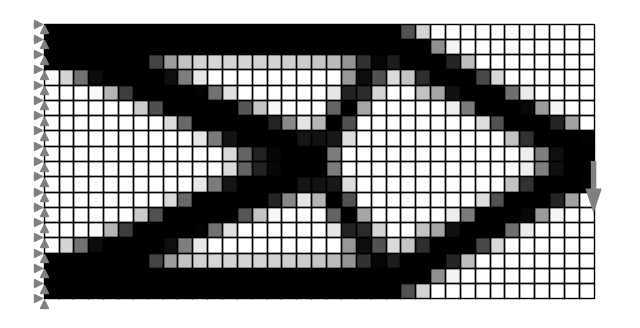

In [8]:
d_opt = optimize_mma(cantilever, rho_0, rho_min, rho_max, V0, p=3, iter=50, r_sens=1.0)
cantilever.plot(element_property=d_opt[-1], cmap="gray_r")
plt.savefig(
    "../figures/cantilever_fem_optimized_binary_filtered.svg",
    transparent=True,
    bbox_inches="tight",
)

Iteration k=  0 - Compliance: 3.15949
Iteration k=  1 - Compliance: 3.48000
Iteration k=  2 - Compliance: 5.39400
Iteration k=  3 - Compliance: 3.02577
Iteration k=  4 - Compliance: 1.54312
Iteration k=  5 - Compliance: 1.14941
Iteration k=  6 - Compliance: 0.90429
Iteration k=  7 - Compliance: 0.82058
Iteration k=  8 - Compliance: 0.79029
Iteration k=  9 - Compliance: 0.77547
Iteration k= 10 - Compliance: 0.76657
Iteration k= 11 - Compliance: 0.76302
Iteration k= 12 - Compliance: 0.76191
Iteration k= 13 - Compliance: 0.76099
Iteration k= 14 - Compliance: 0.76025
Iteration k= 15 - Compliance: 0.75940
Iteration k= 16 - Compliance: 0.75908
Iteration k= 17 - Compliance: 0.75874
Iteration k= 18 - Compliance: 0.75858
Iteration k= 19 - Compliance: 0.75848
Iteration k= 20 - Compliance: 0.75839
Iteration k= 21 - Compliance: 0.75812
Iteration k= 22 - Compliance: 0.75785
Iteration k= 23 - Compliance: 0.75747
Iteration k= 24 - Compliance: 0.75744
Iteration k= 25 - Compliance: 0.75744
Iteration k=

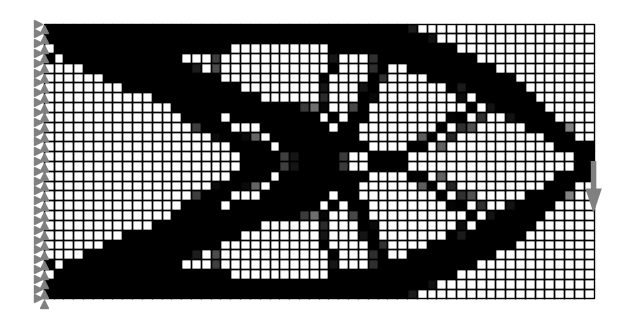

In [9]:
cantilever_fine = get_cantilever(0.5, 28.0, 14.0)

rho_0_f = 0.5 * torch.ones(len(cantilever_fine.elements))
rho_min_f = 0.1 * torch.ones_like(rho_0_f)
rho_max_f = 1.0 * torch.ones_like(rho_0_f)
areas_f = compute_areas(cantilever_fine)
V0 = 0.5 * torch.inner(rho_max_f, areas_f)


rho_opt = optimize_mma(cantilever_fine, rho_0_f, rho_min_f, rho_max_f, V0, p=3, iter=50)
cantilever_fine.plot(element_property=rho_opt[-1], cmap="gray_r")
plt.savefig(
    "../figures/cantilever_fem_optimized_binary_fine.svg",
    transparent=True,
    bbox_inches="tight",
)

Iteration k=  0 - Compliance: 3.15949
Iteration k=  1 - Compliance: 3.58879
Iteration k=  2 - Compliance: 5.59235
Iteration k=  3 - Compliance: 3.19642
Iteration k=  4 - Compliance: 1.57245
Iteration k=  5 - Compliance: 1.17433
Iteration k=  6 - Compliance: 1.01420
Iteration k=  7 - Compliance: 0.86609
Iteration k=  8 - Compliance: 0.81336
Iteration k=  9 - Compliance: 0.78984
Iteration k= 10 - Compliance: 0.76872
Iteration k= 11 - Compliance: 0.76237
Iteration k= 12 - Compliance: 0.75780
Iteration k= 13 - Compliance: 0.75444
Iteration k= 14 - Compliance: 0.75189
Iteration k= 15 - Compliance: 0.75071
Iteration k= 16 - Compliance: 0.74914
Iteration k= 17 - Compliance: 0.74884
Iteration k= 18 - Compliance: 0.74813
Iteration k= 19 - Compliance: 0.74783
Iteration k= 20 - Compliance: 0.74778
Iteration k= 21 - Compliance: 0.74761
Iteration k= 22 - Compliance: 0.74766
Iteration k= 23 - Compliance: 0.74727
Iteration k= 24 - Compliance: 0.74784
Iteration k= 25 - Compliance: 0.74734
Iteration k=

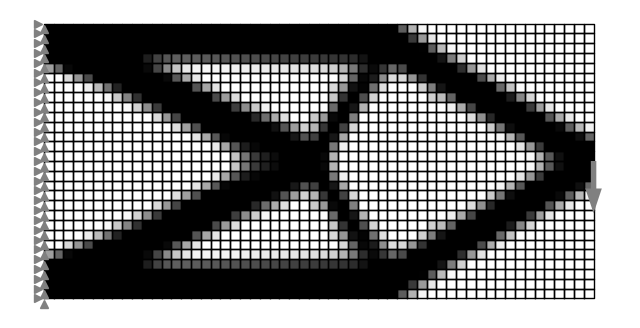

In [10]:
rho_opt = optimize_mma(
    cantilever_fine, rho_0_f, rho_min_f, rho_max_f, V0, p=3, iter=50, r_sens=1.0
)
cantilever_fine.plot(element_property=rho_opt[-1], cmap="gray_r")
plt.savefig(
    "../figures/cantilever_fem_optimized_binary_fine_filtered.svg",
    transparent=True,
    bbox_inches="tight",
)

Iteration k=  0 - Compliance: 3.19738
Iteration k=  1 - Compliance: 3.46626
Iteration k=  2 - Compliance: 5.41301
Iteration k=  3 - Compliance: 3.15927
Iteration k=  4 - Compliance: 1.66375
Iteration k=  5 - Compliance: 1.20163
Iteration k=  6 - Compliance: 0.95243
Iteration k=  7 - Compliance: 0.84727
Iteration k=  8 - Compliance: 0.80169
Iteration k=  9 - Compliance: 0.77944
Iteration k= 10 - Compliance: 0.76927
Iteration k= 11 - Compliance: 0.76396
Iteration k= 12 - Compliance: 0.76124
Iteration k= 13 - Compliance: 0.75965
Iteration k= 14 - Compliance: 0.75654
Iteration k= 15 - Compliance: 0.75515
Iteration k= 16 - Compliance: 0.75427
Iteration k= 17 - Compliance: 0.75316
Iteration k= 18 - Compliance: 0.75255
Iteration k= 19 - Compliance: 0.75118


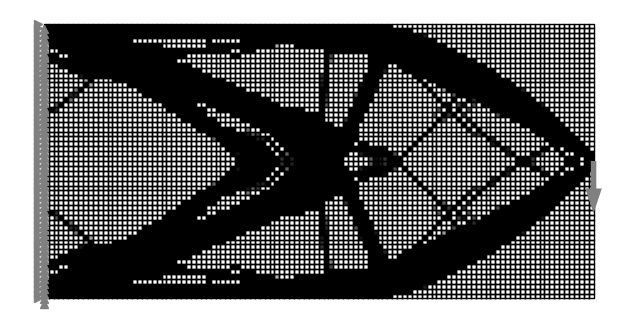

In [11]:
cantilever_extra_fine = get_cantilever(0.25, 28.0, 14.0)

rho_0_xf = 0.5 * torch.ones(len(cantilever_extra_fine.elements))
rho_min_xf = 0.1 * torch.ones_like(rho_0_xf)
rho_max_xf = 1.0 * torch.ones_like(rho_0_xf)
areas_xf = compute_areas(cantilever_extra_fine)
V0 = 0.5 * torch.inner(rho_max_xf, areas_xf)


rho_opt = optimize_mma(
    cantilever_extra_fine, rho_0_xf, rho_min_xf, rho_max_xf, V0, p=3, iter=20
)
cantilever_extra_fine.plot(element_property=rho_opt[-1], cmap="gray_r")
plt.savefig(
    "../figures/cantilever_fem_optimized_binary_extra_fine.svg",
    transparent=True,
    bbox_inches="tight",
)

Iteration k=  0 - Compliance: 3.19738
Iteration k=  1 - Compliance: 3.58924
Iteration k=  2 - Compliance: 5.65584
Iteration k=  3 - Compliance: 3.28497
Iteration k=  4 - Compliance: 1.67591
Iteration k=  5 - Compliance: 1.22087
Iteration k=  6 - Compliance: 1.05201
Iteration k=  7 - Compliance: 0.90092
Iteration k=  8 - Compliance: 0.83648
Iteration k=  9 - Compliance: 0.80396
Iteration k= 10 - Compliance: 0.78370
Iteration k= 11 - Compliance: 0.77625
Iteration k= 12 - Compliance: 0.77003
Iteration k= 13 - Compliance: 0.76624
Iteration k= 14 - Compliance: 0.76360
Iteration k= 15 - Compliance: 0.76140
Iteration k= 16 - Compliance: 0.76024
Iteration k= 17 - Compliance: 0.75867
Iteration k= 18 - Compliance: 0.75808
Iteration k= 19 - Compliance: 0.75715
Iteration k= 20 - Compliance: 0.75676
Iteration k= 21 - Compliance: 0.75635
Iteration k= 22 - Compliance: 0.75601
Iteration k= 23 - Compliance: 0.75591
Iteration k= 24 - Compliance: 0.75545
Iteration k= 25 - Compliance: 0.75568
Iteration k=

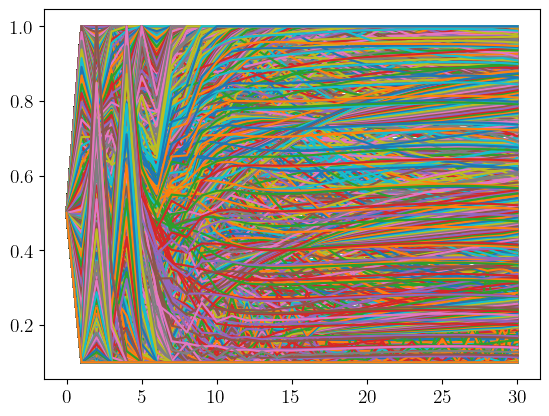

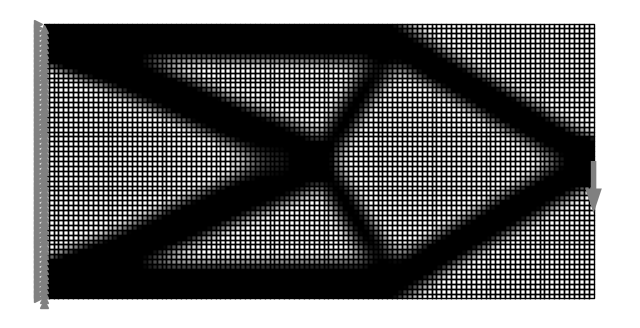

In [12]:
rho_opt = optimize_mma(
    cantilever_extra_fine,
    rho_0_xf,
    rho_min_xf,
    rho_max_xf,
    V0,
    p=3,
    iter=30,
    r_sens=1.0,
)
plt.plot(torch.stack(rho_opt))
plt.show()
cantilever_extra_fine.plot(element_property=rho_opt[-1], cmap="gray_r")
plt.savefig(
    "../figures/cantilever_fem_optimized_binary_extra_fine_filtered.svg",
    transparent=True,
    bbox_inches="tight",
)

## Optimization with optimality conditions

In [13]:
def optimize_oc(
    fem, rho_0, rho_min, rho_max, V_0, iter=15, xi=0.5, m=0.2, p=1.0, r_sens=0.0
):
    k0 = torch.einsum("i,ijk->ijk", 1.0 / fem.thickness, fem.k())
    rho = [rho_0]
    areas = compute_areas(fem)

    # Check if there is a feasible solution before starting iteration
    if torch.inner(rho_min, areas) > V_0:
        raise Exception("rho_min is not compatible with V_0.")

    # Precompute filter weights
    if r_sens > 0.0:
        ecenters = torch.stack([torch.mean(fem.nodes[e], dim=0) for e in fem.elements])
        dist = torch.cdist(ecenters, ecenters)
        H = r_sens - dist
        H[dist > r_sens] = 0.0

    # Iterate solutions
    for k in range(iter):
        # Adjust thickness variables
        fem.thickness = rho[k] ** p
        # Compute solution
        u_k, f_k = fem.solve()
        # Copy original rho
        rho_k = rho[k].clone()

        # Compute sensitivities
        disp = u_k[fem.elements, :].reshape(fem.n_elem, -1)
        w_k = 0.5 * torch.einsum("...i,...ij,...j", disp, k0, disp)
        sensitivity = -p * rho[k] ** (p - 1) * 2.0 * w_k

        # Filter sensitivities (if r_filt provided)
        if r_sens > 0.0:
            sensitivity = H @ (rho[k] * sensitivity) / H.sum(dim=0) / rho[k]

        def make_step(mu):
            # Assuming a certain value of mu, apply the iteration scheme to
            G_k = -sensitivity / (mu * areas)
            upper = torch.min(rho_max, (1 + m) * rho_k)
            lower = torch.max(rho_min, (1 - m) * rho_k)
            rho_trial = G_k**xi * rho_k
            return torch.clamp(rho_trial, lower, upper)

        def g(mu):
            rho_k = make_step(mu)
            return torch.dot(rho_k, areas) - V_0

        mu = bisection(g, 1e-10, 1.0, tol=1e-15)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k} - Compliance: {compliance:.5f}")

        rho.append(make_step(mu))

    return rho

Iteration k=0 - Compliance: 3.13393
Iteration k=1 - Compliance: 2.29492
Iteration k=2 - Compliance: 1.82952
Iteration k=3 - Compliance: 1.50663
Iteration k=4 - Compliance: 1.28084
Iteration k=5 - Compliance: 1.18956
Iteration k=6 - Compliance: 1.12292
Iteration k=7 - Compliance: 1.06040
Iteration k=8 - Compliance: 1.00956
Iteration k=9 - Compliance: 0.96913
Iteration k=10 - Compliance: 0.93354
Iteration k=11 - Compliance: 0.90106
Iteration k=12 - Compliance: 0.87155
Iteration k=13 - Compliance: 0.84559
Iteration k=14 - Compliance: 0.82147
Iteration k=15 - Compliance: 0.80151
Iteration k=16 - Compliance: 0.78556
Iteration k=17 - Compliance: 0.77340
Iteration k=18 - Compliance: 0.76446
Iteration k=19 - Compliance: 0.75858
Iteration k=20 - Compliance: 0.75476
Iteration k=21 - Compliance: 0.75265
Iteration k=22 - Compliance: 0.75130
Iteration k=23 - Compliance: 0.75047
Iteration k=24 - Compliance: 0.74984
Iteration k=25 - Compliance: 0.74935
Iteration k=26 - Compliance: 0.74898
Iteration k

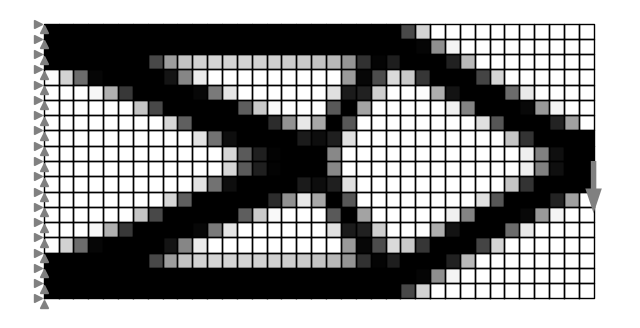

In [14]:
rho_opt = optimize_oc(cantilever, rho_0, rho_min, rho_max, V0, p=3, iter=50, r_sens=1.0)
cantilever.plot(element_property=rho_opt[-1], cmap="gray_r")